In [1]:
import torch, pickle, time, os, random
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import torch_geometric as tg
from torch_geometric.loader import DataLoader
# if torch.cuda.is_available():
#     from accelerate import Accelerator
#     accelerator = Accelerator()
#     device = accelerator.device
### accelerate huggingface to GPU
torch.manual_seed(42)
random.seed(42)

In [2]:
os.listdir('../../../../scratch/gpfs/cj1223/GraphStorage/')

['medium_beforeafter',
 'medium_redshift_50_all',
 'test_onlyhmass_smass',
 'medium_redshift_80_all',
 'test_cut',
 'medium_all_q_diffbeforeafter',
 'vlarge_redshift_85_all',
 'medium_all_smass',
 'medium_onlyhmass_smass',
 'medium_scaleonly_smass',
 'vlarge_redshift_50_all',
 'test_beforeafter',
 'test_all_smass',
 'medium_redshift_15_all',
 'transformers',
 'medium_noinfonoedge_smass',
 'medium_onlyedge_smass',
 'medium_all_variance',
 'medium_redshift_1_all',
 'medium_all_q',
 'medium_redshift_10_all',
 'medium_all_final',
 'vlarge_redshift_95_all',
 'test_variance',
 'small_all_q_variancehalomass',
 'medium_all_residual',
 'medium_all',
 'test',
 'vlarge_all_robust_smass',
 'test_final',
 'vlarge_redshift_99_all',
 'vlarge_redshift_99.99_all',
 'vlarge_redshift_75_all',
 'med_all_residual',
 'medium_redshift_25_all',
 'medium_redshift_0.1_all',
 'vlarge_all_smass',
 'one_all_q',
 'test_redshift_scan',
 'medium_all_finalhalo',
 'test_dev',
 '105lim_all_smass',
 'medium_redshift_5_al

In [3]:
case='vlarge_redshift_95_all'
data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))

In [4]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        
        # Our final linear layer will define our output
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)   

          # 2. Readout layer
#         x = global_max_pool(x, batch)  ## Miles says use sumpool
#         x = global_mean_pool(x, batch)
#         x=concat(x1,x2)
        x = global_add_pool(x, batch)  ## Miles says use sumpool

#         x = F.dropout(x, p=0.1, training=self.training)

        x = self.lin1(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

False

In [8]:
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, LayerNorm
from torch_geometric.nn import SAGEConv, global_mean_pool, norm, global_max_pool, global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, nlin=3):
        super(GCN, self).__init__()
        
        self.conv1 = SAGEConv(data[0].num_node_features, hidden_channels) ##use meta-layer
        ## https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.meta.MetaLayer
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
#         self.conv5 = SAGEConv(hidden_channels, hidden_channels)
        
        
        # Our final linear layer will define our output
        self.norm = LayerNorm(normalized_shape=hidden_channels) # layer_norm instead
        self.lin1 = Linear(hidden_channels, 1)
        
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
#         x = self.conv5(x, edge_index)
#         x = x.relu()
        x = global_add_pool(x, batch)  ## Miles says use sumpool

        x = self.lin1(self.norm(x))
#         x=self.lin1(x)
        return x
    
model = GCN(hidden_channels=32)
next(model.parameters()).is_cuda ##check number one

False

In [9]:
criterion = torch.nn.MSELoss()
n_epochs=50
batch_size=128
split=0.8
n_trials=1
percentiles=[0]
percentiles=[0,75,85,95,99,99.99]
meta={'loss':criterion,
     'n_epochs': n_epochs,
     'batch_size':batch_size,
     'len_data': len(data),
     'percentiles':percentiles}

In [13]:
trains, tests, scatter = [], [], []
yss, preds=[],[]
for percentile in percentiles:
    case=f'vlarge_redshift_{percentile}_all'
    data=pickle.load(open(f'../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
    for q in range(n_trials):
        model = GCN(hidden_channels=32)
        print('Training for ' + case + f' trial {q+1}/{n_trials} with {len(data)} trees')
        test_data=data[int(len(data)*split):]
        train_data=data[:int(len(data)*split)]
        train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=1)
        test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=1)    
        optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
        # _, _, test_loader = accelerator.prepare(model, optimizer, train_loader)
        # model, optimizer, train_loader = accelerator.prepare(model, optimizer, train_loader)

        # Initialize our train function
        def train():
            model.train()

            for data in train_loader: 
#                 print(1)
                out = model(data.x, data.edge_index, data.batch)  
                loss = criterion(out, data.y.view(-1,1)) 
                loss.backward()
        #         accelerator.backward(loss)
                optimizer.step() 
                optimizer.zero_grad() 
         # test function
        def test(loader):
            model.eval()

            correct = 0
            for dat in loader: 
                out = model(dat.x, dat.edge_index, dat.batch) 
        #         print(out)
                correct += (torch.square(out - dat.y.view(-1,1))).sum() 
            return correct / len(loader.dataset) 
        tr_acc, te_acc=[],[]
        start=time.time()
        for epoch in range(n_epochs):
            train()

            if (epoch+1)%2==0:
                train_acc = test(train_loader).detach().numpy()
                test_acc = test(test_loader).detach().numpy()
                tr_acc.append(train_acc)
                te_acc.append(test_acc)
                print(f'Epoch: {epoch+1:03d}, Train scatter: {np.sqrt(train_acc):.4f}, Test scatter: {np.sqrt(test_acc):.4f}')
        tests.append(te_acc)
        trains.append(tr_acc)
        stop=time.time()
        spent=stop-start
        print(f"{spent:.2f} seconds spent training, {spent/n_epochs:.3f} seconds per epoch.\
                Processed {len(data)*split*n_epochs/spent:.0f} trees per second")
        ys, pred=[],[]
        def test(loader):
            model.eval()

            correct = 0
            for dat in loader: 
                out = model(dat.x, dat.edge_index, dat.batch) 
                pred.append(out.view(1,-1).detach().numpy())
                ys.append(np.array(dat.y)) 
        test(test_loader)
        # test(train_loader)
        ys=np.hstack(ys)
        pred=np.hstack(pred)[0]
        yss.append(ys)
        preds.append(pred)
        scatter.append(np.std(ys-pred))

Training for vlarge_redshift_0_all trial 1/1 with 108694 trees
Epoch: 002, Train scatter: 0.1756, Test scatter: 0.1758
Epoch: 004, Train scatter: 0.1315, Test scatter: 0.1300
Epoch: 006, Train scatter: 0.1190, Test scatter: 0.1227
Epoch: 008, Train scatter: 0.1160, Test scatter: 0.1181
Epoch: 010, Train scatter: 0.1197, Test scatter: 0.1228
Epoch: 012, Train scatter: 0.1101, Test scatter: 0.1139
Epoch: 014, Train scatter: 0.1243, Test scatter: 0.1266
Epoch: 016, Train scatter: 0.1196, Test scatter: 0.1234
Epoch: 018, Train scatter: 0.1264, Test scatter: 0.1274
Epoch: 020, Train scatter: 0.1272, Test scatter: 0.1318
Epoch: 022, Train scatter: 0.1011, Test scatter: 0.1083
Epoch: 024, Train scatter: 0.1124, Test scatter: 0.1182
Epoch: 026, Train scatter: 0.1062, Test scatter: 0.1121
Epoch: 028, Train scatter: 0.0987, Test scatter: 0.1075
Epoch: 030, Train scatter: 0.1109, Test scatter: 0.1187
Epoch: 032, Train scatter: 0.0970, Test scatter: 0.1039
Epoch: 034, Train scatter: 0.0967, Test s

Epoch: 014, Train scatter: 0.1559, Test scatter: 0.1541
Epoch: 016, Train scatter: 0.1639, Test scatter: 0.1619
Epoch: 018, Train scatter: 0.1529, Test scatter: 0.1483
Epoch: 020, Train scatter: 0.1539, Test scatter: 0.1521
Epoch: 022, Train scatter: 0.1552, Test scatter: 0.1499
Epoch: 024, Train scatter: 0.1492, Test scatter: 0.1480
Epoch: 026, Train scatter: 0.1502, Test scatter: 0.1498
Epoch: 028, Train scatter: 0.1607, Test scatter: 0.1590
Epoch: 030, Train scatter: 0.1494, Test scatter: 0.1487
Epoch: 032, Train scatter: 0.1577, Test scatter: 0.1565
Epoch: 034, Train scatter: 0.1500, Test scatter: 0.1505
Epoch: 036, Train scatter: 0.1489, Test scatter: 0.1482
Epoch: 038, Train scatter: 0.1587, Test scatter: 0.1572
Epoch: 040, Train scatter: 0.1510, Test scatter: 0.1514
Epoch: 042, Train scatter: 0.1516, Test scatter: 0.1525
Epoch: 044, Train scatter: 0.1617, Test scatter: 0.1543
Epoch: 046, Train scatter: 0.1496, Test scatter: 0.1457
Epoch: 048, Train scatter: 0.1474, Test scatter:

In [14]:
transform='quantile'
transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
scaler=pickle.load(open(transform_path, 'rb'))

In [24]:
Mh=[]
for x in data:
    Mh.append(x.x.numpy()[0,3])
Mh=np.vstack(Mh)
Mh=scaler[10].inverse_transform(Mh)

In [24]:
# x1, x2 = [],[]
# k=0
# for d in train_data:
#     k+=1
#     shape=np.shape(d.x.numpy())
#     x1.append(shape[0])
#     x2.append(shape[1])    

In [29]:
scats=np.split(scatter, np.arange(n_trials, n_trials*len(percentiles), n_trials))
scats

[array([0.09494241], dtype=float32),
 array([0.10436801], dtype=float32),
 array([0.11162545], dtype=float32),
 array([0.12265171], dtype=float32),
 array([0.140076], dtype=float32),
 array([0.14596096], dtype=float32)]

In [78]:
mins=[]
for t in tests:
    mins.append(min(t))
mins=np.sqrt(mins)

In [91]:
errs=abs(np.hstack(scats)-mins)
errs

array([3.6224723e-05, 2.7371198e-04, 1.2444183e-03, 1.8179119e-03,
       7.4727833e-04, 9.3682110e-04], dtype=float32)

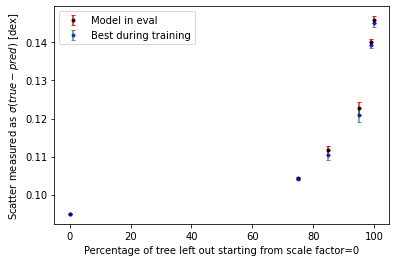

In [94]:
plt.errorbar(percentiles, scats, yerr=errs, color='k', fmt='.', capsize=2, ecolor='r', alpha=0.9, label='Model in eval')
plt.errorbar(percentiles, mins, yerr=errs, color='b', fmt='.', capsize=2, ecolor='g', alpha=0.7, label='Best during training')
plt.xlabel("Percentage of tree left out starting from scale factor=0")
plt.ylabel(r"Scatter measured as $\sigma(true-pred)$ [dex]")
plt.legend()

In [33]:
case='test'
if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results'):
    os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results')

with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results/scatter_{today}.pkl', 'wb') as handle:
    pickle.dump(scatter, handle)
with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results/tests_{today}.pkl', 'wb') as handle:
    pickle.dump(tests, handle)
with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results/trains_{today}.pkl', 'wb') as handle:
    pickle.dump(trains, handle)
with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results/yss_{today}.pkl', 'wb') as handle:
    pickle.dump(yss, handle)
with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/results/preds_{today}.pkl', 'wb') as handle:
    pickle.dump(preds, handle)

In [19]:
percentiles

[80, 10, 1]

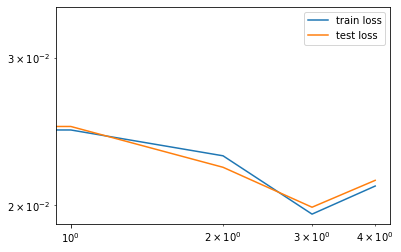

In [11]:
plt.plot(tr_acc, label='train loss')
plt.plot(te_acc, label='test loss')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [82]:
ys, pred=[],[]
def test(loader):
    model.eval()
 
    correct = 0
    for dat in loader: 
        out = model(dat.x, dat.edge_index, dat.batch) 
        pred.append(out.view(1,-1).detach().numpy())
        ys.append(np.array(dat.y)) 
test(test_loader)
# test(train_loader)
ys=np.hstack(ys)
pred=np.hstack(pred)[0]

[Text(0.5, 1.0, 'Residuals, scatter is 0.118'),
 Text(0.5, 0, 'log10(M_stellar)_true-log10(M_stellar)_predicted'),
 Text(0, 0.5, 'N')]

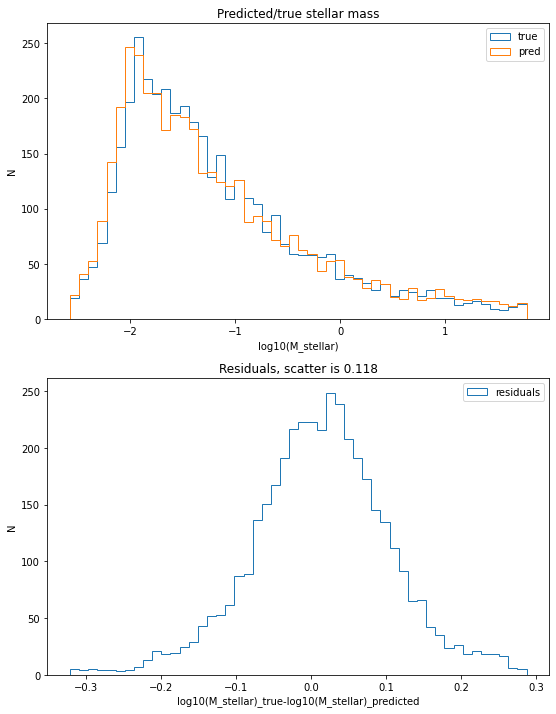

In [83]:
fig, ax= plt.subplots(2, figsize=(9,12))
bins=50
ax[0].hist(ys, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='true',  histtype='step')
ax[0].hist(pred, bins=bins, range=(np.percentile(np.hstack([ys,pred]), [1,99])), label='pred', histtype='step')
ax[1].hist((ys-pred), bins=bins,range=(np.percentile(ys-pred, [1,99])),  histtype='step', label='residuals');
ax[0].legend()
ax[1].legend()
ax[0].set(title='Predicted/true stellar mass', xlabel='log10(M_stellar)', ylabel='N')
ax[1].set(title=f'Residuals, scatter is {np.std(ys-pred):.3f}',xlabel='log10(M_stellar)_true-log10(M_stellar)_predicted', ylabel='N')

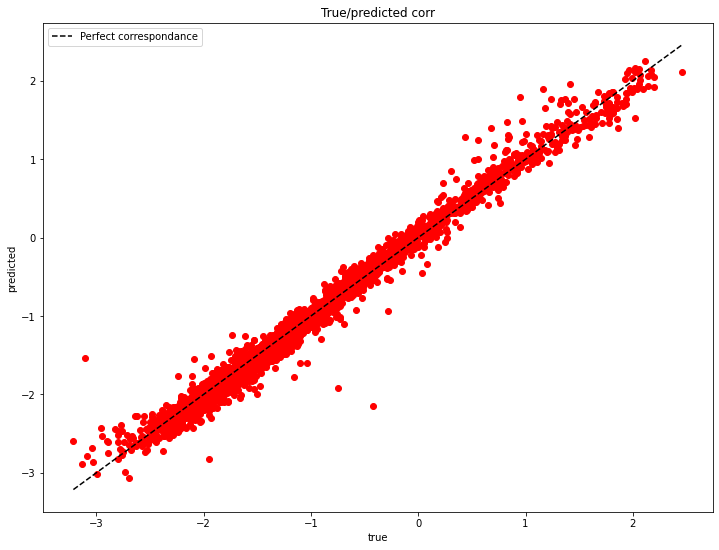

In [84]:
fig, ax =plt.subplots(figsize=(12,9))
ax.plot(ys,pred, 'ro')
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

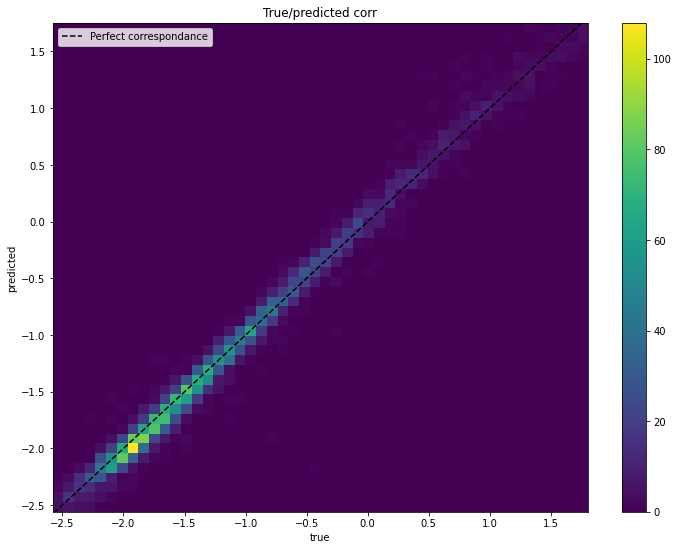

In [85]:
fig, ax =plt.subplots(figsize=(12,9))
h = ax.hist2d(ys,pred, bins=50, range=[np.percentile(ys, [1,99]),np.percentile(pred, [1,99])])
fig.colorbar(h[3], ax=ax)
ax.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
ax.set(xlabel='true',ylabel='predicted', title='True/predicted corr')
ax.legend()

In [86]:
x,y=[], []
for d in data:
    x.append(d.x[0,3].numpy())
    y.append(d.y.numpy())    

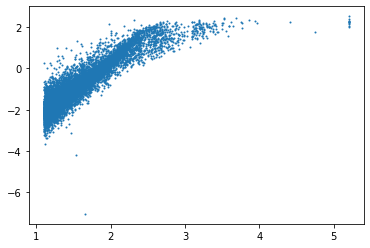

In [87]:
plt.plot(x, y, 'o', markersize=1) 

In [ ]:
## remember to validate that test/val/train are actually comparable
## create toy problem (predict variance of all halo masses eg, verifying that in takes into account edges)
## same, predict average of the difference of post-merge halo and pre merger halos

## try different pools

In [71]:
xte, yte, lte = [], [], []
for d in test_data:
    xte.append(d.x.numpy()[0,3])
    yte.append(d.y.numpy())    
    lte.append(np.log10(len(d.x.numpy()))   ) 
yte=np.vstack(yte)

In [72]:
xtr, ytr, ltr = [], [], []
for d in train_data:
    xtr.append(d.x.numpy()[0,3])
    ytr.append(d.y.numpy())    
    ltr.append(np.log10(len(d.x.numpy()))   ) 
ytr=np.vstack(ytr)

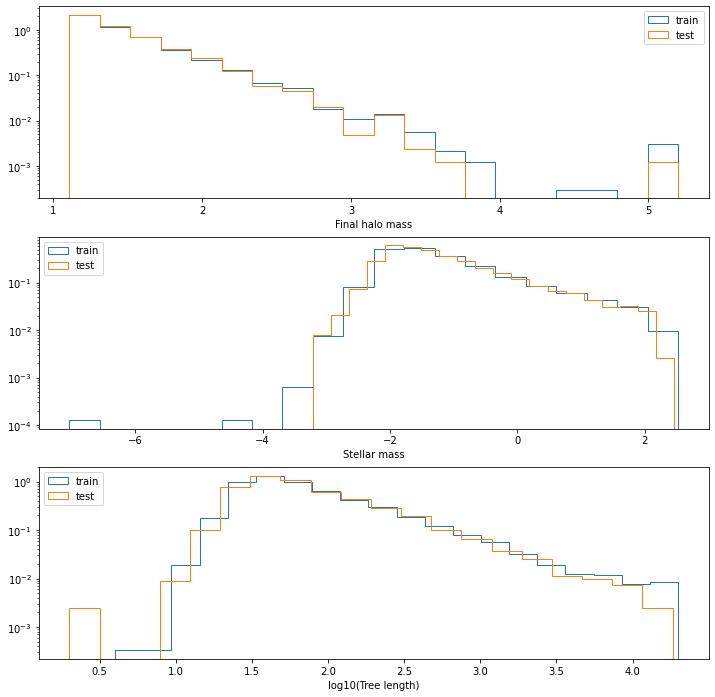

In [73]:
bins=20
fig, ax = plt.subplots(3, figsize=(12,12))
ax[0].hist(xtr, bins=bins, histtype='step', density=1, label='train')
ax[0].hist(xte, bins=bins, histtype='step', density=1, label='test')
ax[0].set(xlabel='Final halo mass')

ax[1].hist(ytr, bins=bins, histtype='step', density=1, label='train')
ax[1].hist(yte, bins=bins, histtype='step', density=1, label='test')
ax[1].set(xlabel='Stellar mass')

ax[2].hist(ltr, bins=bins, histtype='step', density=1, label='train')
ax[2].hist(lte, bins=bins, histtype='step', density=1, label='test');
ax[2].set(xlabel='log10(Tree length)')

for a in ax:
    a.set(yscale='log')
    a.legend()

In [31]:
from datetime import date

today = date.today()

today = today.strftime("%d%m%y")

In [32]:
today

'021121'